In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data_dir = "/media/azhar/Capstone/hieroglyph-image-recognition-imagenet/Augmented_images"
# data_dir = r"C:\Users\Capstone\Desktop\hieroglyph-image-recognition-vgg16\Augmented_images"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = models.resnet50(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

/home/azhar/miniconda3/envs/yolov8/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/azhar/miniconda3/envs/yolov8/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/azhar/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 45.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# # Training loop
# num_epochs = 15
# gradient_accumulation_steps = 4  # Accumulate gradients over 4 batches
# t_loss, v_loss = [], []

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = accumulated_loss = 0.0
#     counter = 0
#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         # optimizer.zero_grad()
#         # optimizer.step()
#         # running_loss += loss.item()

#         # Accumulate gradients
#         accumulated_loss += loss.item()
#         counter += 1

#         if counter % gradient_accumulation_steps == 0:
#             # Perform optimizer step after accumulating gradients for a few batches
#             optimizer.step()
#             optimizer.zero_grad()
#             running_loss += accumulated_loss / gradient_accumulation_steps
#             accumulated_loss = 0.0

#     # Validate the model
#     model.eval()
#     valid_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in valid_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             valid_loss += criterion(outputs, labels).item()

#     t_loss.append(round(running_loss/len(train_loader)), 2)
#     v_loss.append(round(valid_loss/len(valid_loader), 2))
#     # Print the epoch statistics
#     print(f"Epoch {epoch+1}/{num_epochs}: "
#           f"Train Loss: {running_loss / len(train_loader):.4f}, "
#           f"Val Loss: {valid_loss / len(valid_loader):.4f}, "
#           f"Val Accuracy: {100 * correct / total:.2f}%")
num_epochs = 10
gradient_accumulation_steps = 4  # Accumulate gradients over 4 batches
t_loss, v_loss = [], []
accuracy, precision, f1 = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = accumulated_loss = 0.0
    counter = 0
    predictions, true_labels = [], []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()

        # Accumulate gradients
        accumulated_loss += loss.item()
        counter += 1

        if counter % gradient_accumulation_steps == 0:
            # Perform optimizer step after accumulating gradients for a few batches
            optimizer.step()
            optimizer.zero_grad()
            running_loss += accumulated_loss / gradient_accumulation_steps
            accumulated_loss = 0.0

    # Validate the model
    model.eval()
    valid_loss = 0.0
    correct = total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += criterion(outputs, labels).item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    t_loss.append((round(running_loss / len(train_loader), 4)))
    v_loss.append((round(valid_loss / len(valid_loader), 4)))
    accuracy.append(round(100 * correct / total, 2))
    #accuracy.append(round(accuracy_score(true_labels, predictions), 2))
    precision.append(round(precision_score(true_labels, predictions, average='weighted'), 2))
    f1.append(round(f1_score(true_labels, predictions, average='weighted'), 2))

    # Print the epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {t_loss[-1]}, "
          f"Validation Loss: {v_loss[-1]}, "
          f"Validation Accuracy: {accuracy[-1]}, "
          f"Validation Precision: {precision[-1]}, "
          f"Validation F1: {f1[-1]}")



Epoch 1/10: Train Loss: 0.1605, Val Loss: 0.3007, Val Accuracy: 96.55%
Epoch 2/10: Train Loss: 0.0718, Val Loss: 0.1627, Val Accuracy: 97.79%
Epoch 3/10: Train Loss: 0.0404, Val Loss: 0.1115, Val Accuracy: 98.28%
Epoch 4/10: Train Loss: 0.0264, Val Loss: 0.0922, Val Accuracy: 98.51%
Epoch 5/10: Train Loss: 0.0195, Val Loss: 0.0787, Val Accuracy: 98.63%
Epoch 6/10: Train Loss: 0.0153, Val Loss: 0.0727, Val Accuracy: 98.58%
Epoch 7/10: Train Loss: 0.0127, Val Loss: 0.0673, Val Accuracy: 98.77%
Epoch 8/10: Train Loss: 0.0108, Val Loss: 0.0618, Val Accuracy: 98.77%
Epoch 9/10: Train Loss: 0.0095, Val Loss: 0.0598, Val Accuracy: 98.80%
Epoch 10/10: Train Loss: 0.0085, Val Loss: 0.0589, Val Accuracy: 98.82%


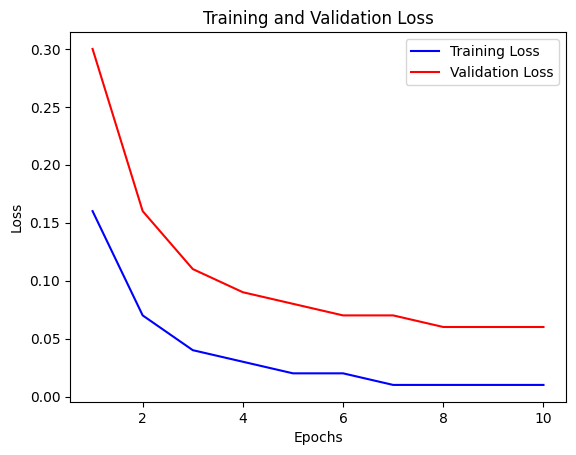

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, valid_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(t_loss, v_loss)

In [ ]:
torch.save(model.state_dict(),'hieroglyph_resnet_2.pth')